# High-Recall CYP3A4 Substrate Classifier using Ensemble Learning

## Scientific Background:

When a new medicine is discovered, a key question is *"How will your body handle it?"* In the liver, a family of enzymes called cytochrome P450(CYPs), especially **CYP3A4**, metabolize (i.e. breaking down) a large share of drugs (about 30–50%). If our drug, call it Drug A, is a CYP3A4 substrate (can be metabolized by CYP3A4), then we must be careful when administering it with other drugs due to Drug-Drug Interaction (DDI) concerns because: 

- if a second drug, (Drug B) inhibits the function of CYP3A4, there won't be enough enzymes to metabolize our Drug A, causing Drug A to accumulate in the body and raise toxicity issues;
- on the other hand, if Drug B increases the production of CYP3A4, it will cause Drug A to be gone from the body before it can carry out its efficacy.

In order to improve the drug to achieve its therapeutic target, scientist must know which enzyme/s is responsible for the metabolism of the drug: is it broken down by CYP3A4 or by others enzymes?

## Goal of the project:

This project applies machine learning to predict whether a compound is a CYP3A4 enzyme substrates based on the compound's structure (SMILEs). With this knowledge we can direct each compound towards the relevant confirmation experiments in the lab, reducing cost and saving time. 



## How to use this tool:

Teams can submit molecules' chemical structure (SMILES string) and get a readout of 0 (False) = Not a substrate, or 1 (True) = Substrate. The tool performs the following steps:
1. Turns SMILE strings into a numerical fingerprint
2. Uses machine learning to estimate the probability of the molecule being a CYP3A4 substrate
3. Applies a recall-first threshold of 0.25 to assign a label: ≥ 0.25 → Substrate (1), < 0.25 → Not a substrate (0)

The compounds predicted as “substrate (1)” go to focused CYP3A4 tests to confirm metabolism and change the chemistry if needed. Those predicted as “Not substrate (0)” will skip 3A4-specific tests and we will look for other ways the body clears them. 


**The model prioritizes Toxicological safety:**

The worst mistake to make is to miss a true substrate (resulting in a False Negative) because a misprediction can hide safety problems until later stages of drug discovery, when experiments and clinical studies are far more costly and risky.

To avoid this, we tuned our model to **favor high recall**. This means we want to minimize False Negatives, and catch as many True Positive substrates as possible, at the expense of more False Positives and the CYP3A4 confirmation tests that would have been conducted without this prediction anyway.

For the sake of this analysis and the reasoning above, we use a lower decision threshold (0.25 in our validation runs), which shows ~90% recall on the testing data set.


*On its own, the model cannot replace wet lab work completely. Rather, the tool will direct compounds to be tested by the relevant lab experiments.*


--------------------

## About the data:

**1) What this dataset is:**
- A peer-reviewed dataset of ~2000 compounds (Nature’s Scientific Data, Aug 14 2025)[1] that says whether a small molecule is metabolized by one of six liver enzymes (CYP1A2, 2C9, 2C19, 2D6, 2E1, 3A4). For this project, we are only interested in and used the data set for CYP3A4.
- From the dataset’s Figshare repository[2], we use the CYP3A4 training and testing CSVs which includes four columns:
    1) Name
    2) SMILES
    3) Label (1 substrate / 0 non-substrate)
    4) Source
- The authors also pre-separated the train/test data sets for five-fold cross-validation, but we merged them and resplit the data

**2) Quick definitions (for non-pharma readers)**
- CYP3A4: a major human liver enzyme that chemically modifies many drugs.
- SMILES strings: a compact, textual way to write a molecule’s structure. It ensures machine readability and can be turned into features by toolkits like RDKit.
- Substrate (1): CYP3A4 does metabolize the compound. Non-substrate (0): CYP3A4 does not metabolize the compound

**3) Data curation:**
- For every compound in the dataset, the team cross-checked at least two independent, reliable references (e.g., Drugbank database, FDA lists, the IU Flockhart table, peer-reviewed papers)
- If a compound's role (substrate or not) show disagreement between references, it is left out of the dataset
- SMILE strings of all compounds in the dataset are canonicalized with RDKit to ensure consistency and reproducibility



Citations:

1. Article: Ni, Y.-H.; Su, Y.-W.; Yang, S.-C.; et al. Curated CYP450 Interaction Dataset: Covering the Majority of Phase I Drug Metabolism. Scientific Data 2025, 12, 1427. https://doi.org/10.1038/s41597-025-05753-8.

2. Dataset (Figshare): Comprehensively-Curated Dataset of CYP450 Interactions: Enhancing Predictive Models for Drug Metabolism. Figshare. https://doi.org/10.6084/m9.figshare.26630515(accessed Aug 30, 2025).

-----------

## 1. Set up and EDA

### Loading data and EDA
We need to check for:
- Shape & nulls: rows, columns, missing values in name, SMILES, label, data_source
- Class balance: count 1’s vs 0’s for CYP3A4; note prevalence (helps pick threshold & CV strategy)
- Exact duplicates: identical SMILES or name duplicates; drop or consolidate.

Imported libraries: pandas, numpy, RDKit, seaborn, matplotlib.pyplot

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training data for CYP3A4
df_train = pd.read_csv('CYP3A4_trainingset.csv')

# Display the first few rows
print("Training Data Head:")
print(df_train.head())

# Get a summary of the dataframe
print("\nTraining Data Info:")
df_train.info()

Training Data Head:
               Name                              SMILES  Label    Source
0    CHLORPROMAZINE    CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21      1  DrugBank
1       GALANTAMINE  COc1ccc2c3c1OC1CC(O)C=CC31CCN(C)C2      1  DrugBank
2         HALOTHANE                     FC(F)(F)C(Cl)Br      1  DrugBank
3        MEXILETINE                 Cc1cccc(C)c1OCC(C)N      1  DrugBank
4  SULFAMETHOXAZOLE     Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1      1  DrugBank

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    2613 non-null   object
 1   SMILES  2613 non-null   object
 2   Label   2613 non-null   int64 
 3   Source  2613 non-null   object
dtypes: int64(1), object(3)
memory usage: 81.8+ KB


Training data looks good. There is no NULL values in any columns.

In [4]:
# Load the testing data for CYP3A4
df_test = pd.read_csv('CYP3A4_testingset.csv')

# Display the first rows
print('Test Data Head:')
print(df_test.head())

# Get summary info for test data
print('\nTest Data Info:')
df_test.info()

Test Data Head:
                   Name                                       SMILES  Label  \
0  N-Desmethylmianserin                c1ccc2c(c1)Cc1ccccc1N1CCNCC21      1   
1           desogestrel       C#CC1(O)CCC2C3CCC4=CCCCC4C3C(=C)CC21CC      1   
2             flutamide  CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1      1   
3              lu25_109                      CCn1nnc(C2=CCCN(C)C2)n1      1   
4           propranolol                  CC(C)NCC(O)COc1cccc2ccccc12      1   

     Source  
0  DrugBank  
1  DrugBank  
2  DrugBank  
3    Holmer  
4  DrugBank  

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    352 non-null    object
 1   SMILES  352 non-null    object
 2   Label   352 non-null    int64 
 3   Source  352 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.1+ KB


Testing data looks good. There is no NULL values in any columns.

#### Merge the two data sets and sanity check

We merged the testing and training data sets, and will be resplitting later

In [5]:
# Merge df_test with df_train and take out the header for df_test
df = pd.concat([df_train, df_test],ignore_index=True)

# Look at the newly merged df_merge heads
print('Merged Data Head:')
print(df.head())

# Look at the info of the merged df
print('\n\nMerged Data info:')
df.info()

# Check for missing values:
print('\n\nNumber of Null entries:')
df.isnull().sum()

# Check for duplicated values:
print('\n\nNumber of Duplicated entries:')
df.duplicated().sum()

Merged Data Head:
               Name                              SMILES  Label    Source
0    CHLORPROMAZINE    CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21      1  DrugBank
1       GALANTAMINE  COc1ccc2c3c1OC1CC(O)C=CC31CCN(C)C2      1  DrugBank
2         HALOTHANE                     FC(F)(F)C(Cl)Br      1  DrugBank
3        MEXILETINE                 Cc1cccc(C)c1OCC(C)N      1  DrugBank
4  SULFAMETHOXAZOLE     Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1      1  DrugBank


Merged Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    2965 non-null   object
 1   SMILES  2965 non-null   object
 2   Label   2965 non-null   int64 
 3   Source  2965 non-null   object
dtypes: int64(1), object(3)
memory usage: 92.8+ KB


Number of Null entries:


Number of Duplicated entries:


0

### Target Variable (Labels = "0" or "1") distribution

Number of compounds per Label:
Label
0    1622
1    1343
Name: count, dtype: int64


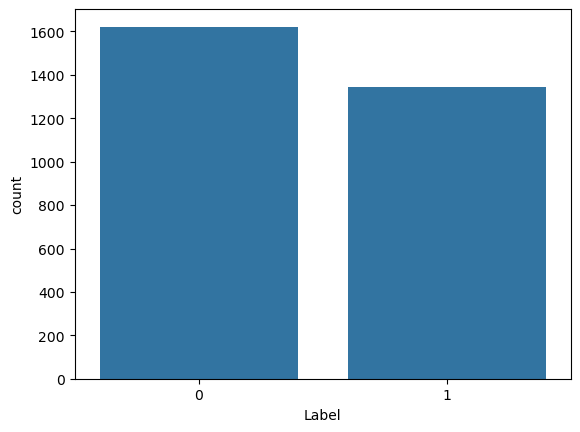

In [6]:
# Look at how many compounds are labeled as each binary category
print('Number of compounds per Label:')
print(df['Label'].value_counts())

# Plot them in a graph
sns.countplot(x="Label", data=df)
plt.show()

### Installing RDKit
We are installing RDKit to process SMILES into Morgan fingerprints

In [7]:
#Install RDKit

!conda install -c conda-forge rdkit -y

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit

# Verify installation
print("RDKit version:", rdkit.__version__)

Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

RDKit version: 2024.03.5


## 2. Convert SMILE strings to Morgan fingerprints
- write a function that takes a SMILES string and converts into a mol object using Chem function from RDKit
- generates a Morgan fingerprint as a bit vector 



In [8]:
def generate_fingerprint(smiles_string):
    """
    Generates a Morgan fingerprint from a single SMILES string.
    Returns None if the SMILES string is invalid.
    """
    # Check if the input is a valid string
    if not isinstance(smiles_string, str):
        return None
    
    # RDKit uses the SMILES string to make a molecute graph, if SMILES is valid, creates a "mol" object
    mol = Chem.MolFromSmiles(smiles_string)
    
    # Check if the molecule was created successfully
    if mol is None:
        return None
        
    # Generate the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return fingerprint

# --- APPLY THE FUNCTION ---
# Apply the transformation for each row's SMILES string in the column "SMILES"
# and runs generate_fingerprint function on it one by one and append them to the new "fingerprints" column.

df['fingerprints'] = df['SMILES'].apply(generate_fingerprint)

# Check for any SMILES that failed to convert in your specific DataFrame
failed_conversions = df['fingerprints'].isna().sum()
print(f"Number of molecules in df that failed to generate a fingerprint: {failed_conversions}")

# Drop rows where fingerprint generation failed
df.dropna(subset=['fingerprints'], inplace=True)

print("\nDataFrame head with new 'fingerprints' column:")
print(df.head())

[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerator
[01:05:49] DEPRECATION WARNING: please use MorganGenerat

Number of molecules in df that failed to generate a fingerprint: 0

DataFrame head with new 'fingerprints' column:
               Name                              SMILES  Label    Source  \
0    CHLORPROMAZINE    CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21      1  DrugBank   
1       GALANTAMINE  COc1ccc2c3c1OC1CC(O)C=CC31CCN(C)C2      1  DrugBank   
2         HALOTHANE                     FC(F)(F)C(Cl)Br      1  DrugBank   
3        MEXILETINE                 Cc1cccc(C)c1OCC(C)N      1  DrugBank   
4  SULFAMETHOXAZOLE     Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1      1  DrugBank   

                                        fingerprints  
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerator
[01:05:50] DEPRECATION WARNING: please use MorganGenerat

## 3. Model Training

Now we will prepare the data and train several classification models to see which performs best.

Prepare Data for Scikit-learn: Separate your features (X) and your target variable (y):
- X: the features the model learns from, the Morgan Fingerprints of each molecule
  
    df['fingerprints'] is a series where each row is a 1-D array/bit-vector of length 2048.
  
    np.stack(...) stacks those 1-D array of fingerprints into a 2-D matrix with shape (n_samples, n_fingerprints).
- y: the ground-truth labels/target as a 1-D NumPy array (0 = not a substrate, 1 = substrate).


Now we are splitting training and testing data sets

In [9]:
from sklearn.model_selection import train_test_split

# Create the feature matrix (X) and target vector (y)
# Builds the two ML inputs:

X = np.stack(df['fingerprints'].values)
y = df['Label'].values

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_test.shape}")

Training set shape: (2372, 2048)
Validation set shape: (593, 2048)


**We get 4 outputs from this step:**

**1. X_train**

What it is: the feature matrix (fingerprints) the model actually learns from.

Shape: (n_train_samples, n_features) i.e., (2372, 2048)

Use: model.fit(X_train, y_train).

**2. y_train**

What it is: the ground-truth labels for each row in X_train.

Shape: (n_train_samples,) i.e., (2372, 1)

Use: paired with X_train during fitting.

**3. X_test**

What it is: a held-out feature matrix used only to check how well the model generalizes while you iterate (hyperparameters, thresholds, etc.).

Shape: (n_test_samples, n_features) i.e., (593, 2048)

Use: model.predict_proba(X_test) → compute AUC/recall/precision, choose threshold, early stopping, etc.

**4. y_test**

What it is: the labels for X_test.

Shape: (n_test_samples,) i.e. (593, 1)

Use: compare against predictions from X_test to compute metrics.

### Train Classification Models: Logistic Regression, Random Forest, and Gradient Boosting.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initialize the models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rand_forest = RandomForestClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)

# Train the models
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

print("Training Random Forest...")
rand_forest.fit(X_train, y_train)

print("Training Gradient Boosting...")
grad_boost.fit(X_train, y_train)

print("All models trained successfully.")

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
All models trained successfully.


We successfully trained the three models above and checked for the ROC AUC curve of each model. From preliminary screening, it appears that Random Forest performs best for this project, therefore we will focus on hypertuning it to see if we can find the best parameters.

### Hypertuning for Random Forest

#### Hypertune parameters:

- **n_estimators (200–999)**: the number of trees in the RF

More trees decrease variance and increase stability, at linear compute cost. Past ~600–800 trees, gains usually plateau. Searching 200–999 lets the tuner balance accuracy vs time.
Each tree is trained on bootstrapped samples (randomly selected with replacement), and will be trained on a subset of the 2048 bits of Morgan Footprints (in our case, we did not specify max_features to be trained so the default is sqrt(2084) = 45)

- **max_depth (None, 10, 20, 30)**: the number of times a node is allowed to split

Increasing max_depth can increase accuracy, but too deep can lead to overfitting.

- **min_samples_split (2–19)**: minimum samples required to split a node.

Larger will lead to fewer splits and more smoothing that increases bias and decrease variance.
With ~2k rows, capping at 19 is enough to prevent hyper-fine, noisy splits.

- **min_samples_leaf (1–19)**: minimum samples per leaf.

This is a strong anti-overfit parameter for RFs.
Values >1 force leaves to represent multiple samples, which improves recall stability on imbalanced data (but too large can underfit the minority class).

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. Define the parameters
param_dist = {
    'n_estimators': randint(200, 1000),      # Number of trees
    'max_depth': [None, 10, 20, 30],         # Max depth of each tree
    'min_samples_split': randint(2, 20),     # Min samples to split a node
    'min_samples_leaf': randint(1, 20),      # Min samples in a leaf node
}

# 2. Create the RandomizedSearchCV object
# This will test random combinations of the parameters above using 5-fold cross-validation
rand_search = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state=42), # Use a fresh RF model at each trial, random_state makes it reproducible
    param_distributions = param_dist,
    n_iter = 50,                  # We'll test 50 different combinations
    cv = 5,                       # Use 5-fold stratified cross-validation
    scoring = 'roc_auc',          # Our goal is to improve ROC AUC
    n_jobs = -1,                  # Use all available CPU cores to speed it up
    random_state = 42,
    verbose = 1                   # Print progress
)

# 3. Run the search on training data
print("🚀 Starting hyperparameter tuning...")
rand_search.fit(X_train, y_train)

# 4. Print the results
print("✅ Tuning complete!")
print(f"Best parameters found: {rand_search.best_params_}")
print(f"Best cross-validated ROC AUC score: {rand_search.best_score_:.4f}")

# The best, fully-trained model is now stored in rand_search.best_estimator_
best_random_forest = rand_search.best_estimator_

🚀 Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Tuning complete!
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 944}
Best cross-validated ROC AUC score: 0.8811


**Now that the model found the best parameters, let's take a look at what they are and see if they make sense for our dataset**

In [12]:
res = pd.DataFrame(rand_search.cv_results_)
res = res.sort_values('mean_test_score', ascending=False)

print ('\nHypertuned Random Forest Best Estimator parameters:')
res[['mean_test_score','param_n_estimators','param_max_depth','param_min_samples_split','param_min_samples_leaf']].head(10)


Hypertuned Random Forest Best Estimator parameters:


,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf
40,0.881056,944,None,14,1
22,0.879835,847,30,13,1
29,0.878092,938,30,2,3
8,0.878049,846,30,6,3
49,0.876096,929,20,13,2
3,0.875934,613,20,13,2
24,0.875711,578,20,2,3
2,0.874348,863,30,9,4
36,0.873749,359,None,14,4
34,0.873293,606,30,6,4


n_estimators = 944: more trees give more chances to capture different local chemical patterns from the Morgan Fingerprints, thus giving us a better result.

max_depth = None : this makes sense because we don't want to manually cap the tree splits as the Morgan Fingerprints are high-dimensional and sparse.

min_samples_split = 14 and min_samples_leaf = 1: a node must have ≥14 samples to split so it naturally limits the depth.

**The best parameters that we found after hypertuning gives us a model with ROC AUC of 0.88. It is acceptable but we want to try to see if we can find something that works better.**

### Trying a more powerful boosting model: LightGBM

In [13]:
# First, install the lightgbm package
!pip install lightgbm

# Then import the required libraries
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 1. Initialize and train the LightGBM model
print("🚀 Training LightGBM model...")
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# 2. Evaluate on the validation set
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

print(f"✅ LightGBM ROC AUC on validation set: {roc_auc_lgbm:.4f}")

🚀 Training LightGBM model...
[LightGBM] [Info] Number of positive: 1074, number of negative: 1298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 2372, number of used features: 1136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452782 -> initscore=-0.189435
[LightGBM] [Info] Start training from score -0.189435
✅ LightGBM ROC AUC on validation set: 0.8914


AUC of 0.8914 is good but not improved by much from RF. Let's try to fine tune it manually using some of the parameters we explored in hypertuning of the RF

In [14]:
lgbm2 = lgb.LGBMClassifier(
    objective="binary",         # set to binary so that it uses logistic loss
    n_estimators=1000,          # high capacity and control
    learning_rate=0.01,         # decreased rate: small steps with higher number of trees
    num_leaves=83,              # increased the leaves, defual of 31 might be too shallow for chemistry
    min_data_in_leaf=1,         # more granular splits, can learn smaller features from MF
    subsample=0.8,              # takes 80% of rows for sampling (ike bagging in RF) to prevent overfitting
    subsample_freq=1,
    colsample_bytree=0.8,       # feature sampling: uses 80% of MF to sample
    reg_lambda=1.0,             # L2 regularization on leaf weight, helps with not overfitting since by min leaf is 1
    random_state=42,
    n_jobs=1,                   # more reproducible
    min_child_samples=None
)

# Fit the model's ROC AUC curve
lgbm2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="roc_auc",

)

# Print out AUC score for lgbm2:
y_pred_proba_lgbm2 = lgbm2.predict_proba(X_test)[:, 1]
roc_auc_lgbm2 = roc_auc_score(y_test, y_pred_proba_lgbm2)
print(f"lgbm2 AUC: {roc_auc_lgbm2:.4f}")


[LightGBM] [Info] Number of positive: 1074, number of negative: 1298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 2372, number of used features: 2048
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452782 -> initscore=-0.189435
[LightGBM] [Info] Start training from score -0.189435
lgbm2 AUC: 0.8990


Manual tuning of the LightGBM model:

- n_estimators=1000, leaning_rate = 0.01, and num_leaves=83: Increasing the number of trees while reducing the learning rate allows the model to learn gradually and capture subtle structure in the data. A larger number of leaves makes the trees more expressive. This combination improves precision but increases the risk of overfitting, which is mitigated by the regularization settings below
- min_data_in_leaf=1 : enables the model to capture rare but potentially important feature patterns in sparse fingerprint data
- subsample=0.8 : each tree is trained on 80% of the training samples, chosen randomly. It reduces variance and overfitting, similar to bagging in RF
- colsample_bytree=0.8 : each tree is trained on 80% of features chosen at random. It reduces correlation between trees which prevents overfitting to specific features

**This model shows the best ROC AUC score = 0.9, and we will proceed at looking at all model's classification reports to choose the most adequate one for the project.**

### Classification report for all trained models:

In [15]:
from sklearn.metrics import classification_report

models = {'Logistic Regression': log_reg, 'Tuned Random Forest': best_random_forest, 'Gradient Boosting': grad_boost, 'LightGBM': lgbm, 'LightGBM_tuned' : lgbm2 }

for name, model in models.items():
    print(f"--- Evaluation for {name} ---")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print ROC AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {auc_score:.4f}\n")

--- Evaluation for Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       324
           1       0.74      0.77      0.75       269

    accuracy                           0.77       593
   macro avg       0.77      0.77      0.77       593
weighted avg       0.77      0.77      0.77       593

ROC AUC Score: 0.8740

--- Evaluation for Tuned Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       324
           1       0.79      0.82      0.81       269

    accuracy                           0.82       593
   macro avg       0.82      0.82      0.82       593
weighted avg       0.82      0.82      0.82       593

ROC AUC Score: 0.8884

--- Evaluation for Gradient Boosting ---
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      

Note: auc_score = roc_auc_score(y_test, y_pred_proba)
Why do we need y_pred_probability as an input? Each model makes a prediction of a compound being a 1, given in probabilistic terms. Then because there is already a hidden threshold that the model has given you (0.5), it will compare the probability to the threshold and assign a 0 or 1. After that, it will compare it to the ground truth of y_test to see whether its a TP, FP, TN, FN. From which you can calculate TPR and FPR, resulting in a point on the ROC graph, representing a threshold

## 4. ROC curve

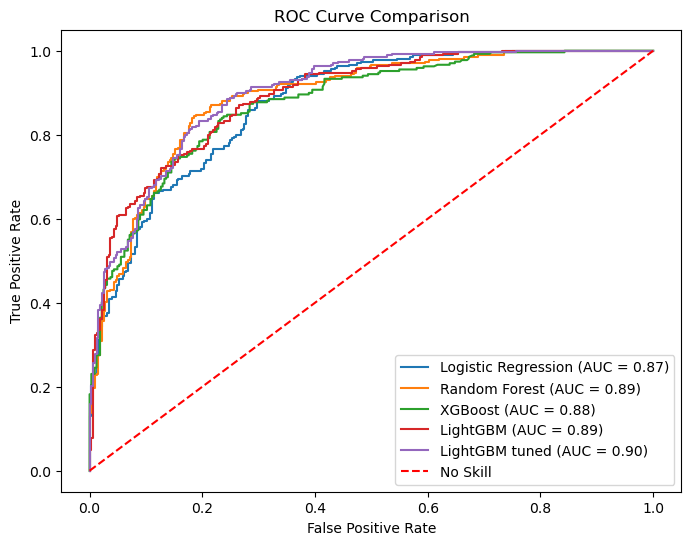

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Get probabilities for each model ---
y_probs_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_probs_rand_forest = best_random_forest.predict_proba(X_test)[:, 1]
y_probs_grad_boost = grad_boost.predict_proba(X_test)[:, 1]
y_probs_LightGBM = lgbm.predict_proba(X_test)[:, 1]
y_probs_LightGBM_tuned = lgbm2.predict_proba(X_test)[:, 1]

# --- Calculate ROC curve points and AUC for each model ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_log_reg)
auc_lr = roc_auc_score(y_test, y_probs_log_reg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rand_forest)
auc_rf = roc_auc_score(y_test, y_probs_rand_forest)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_grad_boost)
auc_xgb = roc_auc_score(y_test, y_probs_grad_boost)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_probs_LightGBM)
auc_lgbm = roc_auc_score(y_test, y_probs_LightGBM)

fpr_lgbm2, tpr_lgbm2, _ = roc_curve(y_test, y_probs_LightGBM_tuned)
auc_lgbm2 = roc_auc_score(y_test, y_probs_LightGBM_tuned)

# --- Plot both curves ---
plt.figure(figsize=(8, 6))
# Plot Logistic Regression
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
# Plot Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
# Plot XGBoost 
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
# Plot LightGBM 
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')
# Plot LightGBM_tuned 
plt.plot(fpr_lgbm2, tpr_lgbm2, label=f'LightGBM tuned (AUC = {auc_lgbm2:.2f})')

# Plot No Skill line
plt.plot([0, 1], [0, 1], 'r--', label='No Skill') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### True Positive Rate (TPR) and False Positive Rate (FPR) of ROC curve

#### TPR and False Negative Risk

The formula for the True Positive Rate is:

**TPR = TP / FN+TP**

To mitigate the high risk of a false negative, the goal is to make the FN term in the denominator as close to zero as possible. Minimizing FN directly maximizes TPR (Sensitivity/recall).

#### FPR and False Positive Risk

The formula for the False Positive Rate is:

**FPR = FP / TN+FP**

To achieve a very high TPR, we must lower our decision threshold. This inevitably causes more true negatives to be misclassified as positives, increasing the FP term in the numerator. Because our goals is to avoid the high risk of false negatives, we must accept a higher FPR.

### Cost of False Negatives vs. False Positives:

**False Positive:** The model predicts a compound is a substrate, but it isn't.

Cost: Moderate. A good compound is flagged for a potential DDI liability. This triggers a confirmatory in vitro assay (e.g., using human liver microsomes). We spend extra time and resources testing a compound that will ultimately be cleared, potentially delaying its progress.

**False Negative:** The model predicts a compound is not a substrate, but it actually is.

Cost: Very High. A compound with a significant, undiscovered DDI risk is advanced in the drug discovery pipeline. This liability might not be caught until much later, more expensive preclinical or clinical studies. A late-stage failure due to a preventable DDI issue wastes millions of dollars and represents a major safety risk.

**We see that the cost of a false negative is significantly higher than the cost of a false positive.**
Thus we will choose a model with the highest possible True Positive Rate (TPR), or Sensitivity: we will choose the model whose curve is furthest to the top-left on the ROC plot. 

In [17]:
# Get predicted probabilities for the validation set
y_pred_proba = best_random_forest.predict_proba(X_test)[:, 1]

# Test a lower threshold
chosen_threshold = 0.33
y_pred_custom = (y_pred_proba >= chosen_threshold).astype(int)

# Print the classification report
print(f"Classification Report for threshold Random Forest = {chosen_threshold}:\n")
print(classification_report(y_test, y_pred_custom, target_names=["Not a Substrate (0)", "Is a Substrate (1)"]))

Classification Report for threshold Random Forest = 0.33:

                     precision    recall  f1-score   support

Not a Substrate (0)       0.91      0.65      0.76       324
 Is a Substrate (1)       0.69      0.92      0.79       269

           accuracy                           0.77       593
          macro avg       0.80      0.79      0.77       593
       weighted avg       0.81      0.77      0.77       593



In [18]:
from sklearn.metrics import classification_report

# Get predicted probabilities for the validation set
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

# Test a lower threshold
chosen_threshold = 0.25
y_pred_custom = (y_pred_proba >= chosen_threshold).astype(int)

# Print the classification report
print(f"Classification Report for threshold LightGBM = {chosen_threshold}:\n")
print(classification_report(y_test, y_pred_custom, target_names=["Not a Substrate (0)", "Is a Substrate (1)"]))

Classification Report for threshold LightGBM = 0.25:

                     precision    recall  f1-score   support

Not a Substrate (0)       0.89      0.67      0.77       324
 Is a Substrate (1)       0.70      0.90      0.79       269

           accuracy                           0.78       593
          macro avg       0.79      0.79      0.78       593
       weighted avg       0.80      0.78      0.78       593



In [19]:
# Get predicted probabilities for the validation set
y_pred_proba = lgbm2.predict_proba(X_test)[:, 1]

# Test a lower threshold
chosen_threshold = 0.2
y_pred_custom = (y_pred_proba >= chosen_threshold).astype(int)

# Print the classification report
print(f"Classification Report for threshold LightGBM_tuned = {chosen_threshold}:\n")
print(classification_report(y_test, y_pred_custom, target_names=["Not a Substrate (0)", "Is a Substrate (1)"]))

Classification Report for threshold LightGBM_tuned = 0.2:

                     precision    recall  f1-score   support

Not a Substrate (0)       0.91      0.67      0.77       324
 Is a Substrate (1)       0.70      0.92      0.79       269

           accuracy                           0.78       593
          macro avg       0.81      0.80      0.78       593
       weighted avg       0.82      0.78      0.78       593



#### Analysis
- **Focus on "Is a Substrate (1)"**:

    Across all three models, recall remains above 0.90, meaning each model successfully identifies the majority of CYP3A4 substrates.

    The tuned LightGBM achieves the best balance of recall and precision:

    - Recall = 0.92: the model correctly identifies 92% of all true substrates, minimizing false negatives. This is crucial in early drug discovery, where missing a true substrate could lead to downstream safety or efficacy risks.

    - Precision = 0.70: of all compounds predicted as substrates, 70% are true positives, while 30% are false positives.

- **Threshold selection (0.2):**

    We selected a lower probability threshold (0.2) to prioritize recall.

    At this threshold, the model captures more true substrates, minimizes false negatives at the cost of introducing more false positives.

    This aligns with our project objective: reducing false negatives is more important than perfectly optimizing precision.


- **Why LightGBM tuned is the best choice:**

    Compared to Random Forest and baseline LightGBM, the tuned LightGBM achieved:

    **Highest recall (0.92)**: minimizes the most critical error (false negatives).

    **Highest precision (0.70)** among the three: reduces wasted resources from false positives compared to other models.

    **Best ROC AUC (0.8990)**: indicates strong overall model ranking ability across thresholds.

Therefore, we select tuned LightGBM at threshold = 0.2 for deployment.

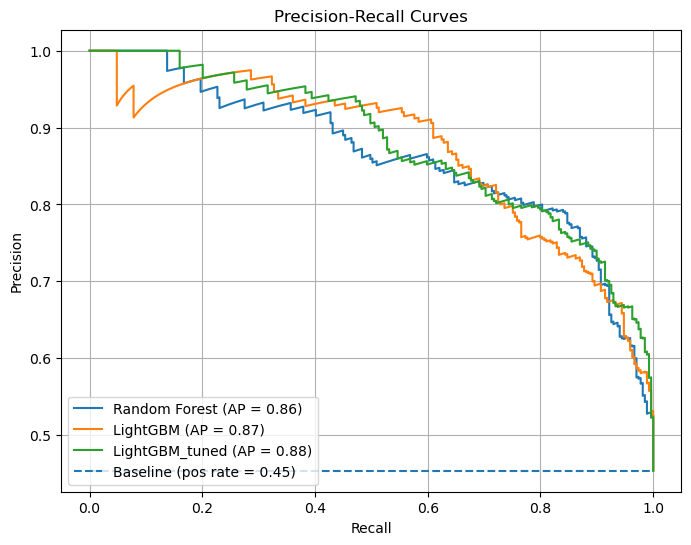

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

models = {
    "Random Forest": best_random_forest,
    "LightGBM": lgbm,
    "LightGBM_tuned": lgbm2
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")

# Baseline = positive class prevalence
pos_rate = np.mean(y_test)
plt.hlines(pos_rate, 0, 1, linestyles='dashed', label=f"Baseline (pos rate = {pos_rate:.2f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid()
plt.show()


#### Analysis:

The precision–recall (PR) curves shows that the tuned LightGBM model consistently achieved the best balance between precision and recall, with an average precision (AP) of 0.88 compared to 0.87 for standard LightGBM and 0.86 for Random Forest. 

Considering that the baseline AP given the class distribution is approximately equal to the prevalence of substrates (~0.45), all three models provide nearly double the expected performance of random guessing. 

Importantly, in the high-recall region (>0.9), the tuned LightGBM curve remains slightly above the others, indicating that it retains higher precision while still capturing the vast majority of true substrates. 

This confirms that LightGBM tuned is the most suitable model for deployment, as it offers both strong overall discrimination and practical reliability in early-stage drug screening where recall is prioritized over precision.

# Conclusion

In this project, we built a machine learning model to predict whether a chemical compound is a substrate for the CYP3A4 enzyme, a critical factor in early-stage drug discovery. The primary goal was to prioritize toxicological safety by minimizing the risk of False Negatives, meaning incorrectly classifying a true substrate as a non-substrate.

Using a curated dataset of nearly 3,000 compounds, we converted molecular structures from SMILES strings into 2048-bit Morgan fingerprints to use as model features. 

After evaluating several algorithms, including Logistic Regression, Random Forest, and Gradient Boosting, a manually tuned LightGBM model demonstrated the best overall performance. Because we focus on diminishing False Negatives, we chose the tuned LightGBM model as it can achieve high recall of 0.92 on substrate class (1) while maintaining usable precision ≈ 0.70. This ensures that the vast majority of true substrates are correctly identified for the appropriate experimental testing, directly aligning with the project's safety-first objective. 

The resulting tool provides a reliable, data-driven method to help scientists triage compounds, focus lab resources more efficiently, and de-risk potential drug candidates earlier in the discovery pipeline.

# Path forward: 
1. Deployment as an Interactive Screening Tool:
    the model is deployed as a user-friendly web application on Hugging Face Spaces. This tool directly translates the model's predictive power into a practical resource for chemists and project teams.

    - Functionality:
      - Batch Processing: The application allows users to upload a file containing multiple SMILES strings, enabling the rapid screening of entire compound libraries at once.
      - Adjustable Threshold: Users have the flexibility to set their own decision threshold. This allows them to balance the trade-off between recall (sensitivity) and precision, depending on the specific needs of their project stage. For early-stage safety screening, the recommended recall-first threshold of 0.2 remains the default guidance.



2. Expansion to Other CYP Enzymes:

    The original dataset contained curated data for five other major CYP enzymes (CYP1A2, 2C9, 2C19, 2D6, 2E1). The methodology established in this project can be directly applied to build separate classification models for each of these enzymes, creating a comprehensive suite of DDI prediction tools.

3. Exploration of Advanced Features:

    Future iterations could explore incorporating additional molecular descriptors (e.g., physicochemical properties like LogP, molecular weight, or polar surface area) alongside the Morgan fingerprints. This enriched feature set could potentially capture different aspects of molecular structure and further improve predictive accuracy.

--------------------

#### Serializing my model

In [21]:
import joblib

joblib.dump(lgbm2, 'cyp3a4_lgbm2model.joblib')

['cyp3a4_lgbm2model.joblib']